# **VGG16 básico con fine-tuning (Adam)**

## **Importar dataset**

In [97]:
import kagglehub    # Libreria para la descarga de archivos de kaggle

# Download latest version
path = kagglehub.dataset_download("gpiosenka/railway-track-fault-detection-resized-224-x-224")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/railway-track-fault-detection-resized-224-x-224


## **Directorios**

In [98]:
# Necesitaremos la librería os, que nos permite interactuar con el sistema operativo y manipular rutas.
import os

# Directorio de entrenamiento:
train_dir = os.path.join(path, 'train')
# Directorio de pruebas:
test_dir = os.path.join(path, 'test')
# Directorio de validacion:
valid_dir = os.path.join(path, 'valid')

## **Importar modelos**

In [99]:
# Los modelos pre-entrenados se encontrarán en la librería de tensorflow.
import tensorflow as tf

# Aprovechamos para fijar la semilla y evitar la aleatoriedad entre simulaciones.
import random
import numpy as np

# Fijar semillas
Semilla = 42
os.environ['PYTHONHASHSEED'] = str(Semilla) # Controlamos la aleatoridad en el hashing de objetos.
random.seed(Semilla)                        # Controlamos la aleatoridad en la generación de números aleatorios.
np.random.seed(Semilla)                     # Controlamos la aleatoridad en la generación de números aleatorios en numpy.
tf.random.set_seed(Semilla)                 # Controlamos la aleatoridad en la generación de números aleatorios en tensorflow.

# Configurar comportamiento determinista en TensorFlow
os.environ['TF_DETERMINISTIC_OPS'] = '1'    # Configuramos una variable de entorno destinada a ciertas operaciones no deterministas como deterministas.

### VGG16

In [100]:
def modelo_base ():
  VGG16_Base = (tf.keras.applications.VGG16(include_top=False,        # Eliminamos su clasificador.
                                          weights='imagenet',         # Mantenemos los pesos de cada capa.
                                          input_shape=(224, 224, 3))) # Especificamos el tamaño de los datos de entrada.
  # Congelamos el modelo.
  for layer in VGG16_Base.layers:
    layer.trainable = False
  return VGG16_Base

## **Entrenamiento**

### Datos de entrada

In [101]:
# Importamos la clase ImageDataGenerator contenido en Keras.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [102]:
datagen = ImageDataGenerator(rescale=1./255)

# Definimos los generadores para cada uno de los conjuntos.
train_data = datagen.flow_from_directory(
    train_dir,                 # Directorio de datos original.
    batch_size=32,             # Cantidad de datos por iteración.
    class_mode='categorical',  # Tipo categórico (defectuoso y no defectuoso).
    color_mode="rgb",          # Escala de colores.
    target_size=(224, 224),    # Tamaño de los datos a la salida.
    subset='training'          # Nombre del subset originado.
)
validation_data = datagen.flow_from_directory(
    valid_dir,                 # Directorio de datos original.
    batch_size=32,             # Cantidad de datos por iteración.
    class_mode='categorical',  # Tipo categórico (defectuoso y no defectuoso).
    color_mode="rgb",          # Escala de colores.
    target_size=(224, 224),    # Tamaño de los datos a la salida.
    shuffle=False              # Mezcla de los datos.
)
test_data = datagen.flow_from_directory(
    test_dir,                  # Directorio de datos original.
    batch_size=32,             # Cantidad de datos por iteración.
    class_mode='categorical',  # Tipo categórico (defectuoso y no defectuoso).
    color_mode="rgb",          # Escala de colores.
    target_size=(224, 224),    # Tamaño de los datos a la salida.
    shuffle=False              # Mezcla de los datos.
)

Found 299 images belonging to 2 classes.
Found 62 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


### Modelo VGG16 (0.01)

In [103]:
# Definimos el modelo base
VGG16_Base = modelo_base()

# Creamos un modelo nuevo.
VGG16_001 = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
VGG16_001.add(VGG16_Base)

# Añadimos el clasificador categórico.
VGG16_001.add(tf.keras.layers.Flatten())
VGG16_001.add(tf.keras.layers.Dense(500, activation='relu'))
VGG16_001.add(tf.keras.layers.Dense(200, activation='relu'))
VGG16_001.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
VGG16_001.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 500)            │    12,544,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,359,790 (104.37 MB)

 Trainable params: 12,645,102 (48.24 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [104]:
# Para realizar la simulación o entrenamiento emplearemos dos librerías.
from keras import optimizers # Contiene optimizadores, encargados de ajustar los pesos.
import time

In [105]:
# Compilamos el modelo antes definido.
VGG16_001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.SGD(learning_rate = 0.01),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_001_start_time = time.time()
VGG16_001_history = VGG16_001.fit(
    train_data,
    epochs=80,
    validation_data=validation_data)

Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 307ms/step - acc: 0.5221 - loss: 2.3281 - val_acc: 0.5000 - val_loss: 0.6604
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - acc: 0.5777 - loss: 0.7654 - val_acc: 0.5000 - val_loss: 0.7129
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - acc: 0.6084 - loss: 0.6479 - val_acc: 0.5000 - val_loss: 0.7589
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - acc: 0.5488 - loss: 0.6549 - val_acc: 0.5000 - val_loss: 0.6809
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - acc: 0.6208 - loss: 0.6728 - val_acc: 0.5968 - val_loss: 0.6193
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - acc: 0.6220 - loss: 0.6430 - val_acc: 0.7742 - val_loss: 0.5663
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - acc: 0.7714 - loss: 0.5567 - val_acc: 0.5484 - val_loss: 0.6567
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - acc: 0.6769 - loss: 0.5540 - val_acc: 0.6452 - val_loss: 0.5699
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - ac

In [106]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_001_acc1 = VGG16_001_history.history['acc']
VGG16_001_val_acc1 = VGG16_001_history.history['val_acc']
VGG16_001_loss1 = VGG16_001_history.history['loss']
VGG16_001_val_loss1 = VGG16_001_history.history['val_loss']

In [107]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in VGG16_Base.layers[-2:]:
    layer.trainable = True

# Compilamos nuevamente el modelo
VGG16_001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.SGD(learning_rate = 0.01),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_001_history = VGG16_001.fit(
    train_data,
    epochs=80,
    validation_data=validation_data)
VGG16_001_end_time = time.time()
print(f"Tiempo de ejecución: {VGG16_001_end_time - VGG16_001_start_time} segundos")

Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - acc: 0.8231 - loss: 0.5159 - val_acc: 0.7419 - val_loss: 0.4758
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - acc: 0.7510 - loss: 0.5397 - val_acc: 0.6613 - val_loss: 0.6903
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - acc: 0.8312 - loss: 0.3739 - val_acc: 0.7903 - val_loss: 0.4446
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - acc: 0.8563 - loss: 0.3866 - val_acc: 0.6452 - val_loss: 0.5703
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - acc: 0.8736 - loss: 0.3204 - val_acc: 0.8387 - val_loss: 0.3835
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - acc: 0.9305 - loss: 0.1986 - val_acc: 0.8548 - val_loss: 0.3560
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - acc: 0.9033 - loss: 0.1838 - val_acc: 0.8387 - val_loss: 0.3943
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - acc: 0.9704 - loss: 0.1394 - val_acc: 0.6129 - val_loss: 0.9461
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - ac

In [108]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_001_acc2 = VGG16_001_history.history['acc']
VGG16_001_val_acc2 = VGG16_001_history.history['val_acc']
VGG16_001_loss2 = VGG16_001_history.history['loss']
VGG16_001_val_loss2 = VGG16_001_history.history['val_loss']

### Modelo VGG16 (0.005)

In [109]:
# Definimos el modelo base
VGG16_Base = modelo_base()

# Creamos un modelo nuevo.
VGG16_0005 = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
VGG16_0005.add(VGG16_Base)

# Añadimos el clasificador categórico.
VGG16_0005.add(tf.keras.layers.Flatten())
VGG16_0005.add(tf.keras.layers.Dense(500, activation='relu'))
VGG16_0005.add(tf.keras.layers.Dense(200, activation='relu'))
VGG16_0005.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
VGG16_0005.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 500)            │    12,544,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,359,790 (104.37 MB)

 Trainable params: 12,645,102 (48.24 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [110]:
# Para realizar la simulación o entrenamiento emplearemos dos librerías.
from keras import optimizers # Contiene optimizadores, encargados de ajustar los pesos.
import time

In [111]:
# Compilamos el modelo antes definido.
VGG16_0005.compile(loss='categorical_crossentropy',
                optimizer=optimizers.SGD(learning_rate = 0.005),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_0005_start_time = time.time()
VGG16_0005_history = VGG16_0005.fit(
    train_data,
    epochs=80,
    validation_data=validation_data)

Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - acc: 0.4708 - loss: 1.3846 - val_acc: 0.5645 - val_loss: 0.6422
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - acc: 0.5677 - loss: 0.6719 - val_acc: 0.7097 - val_loss: 0.6013
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - acc: 0.6046 - loss: 0.6801 - val_acc: 0.6774 - val_loss: 0.6189
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - acc: 0.6218 - loss: 0.6205 - val_acc: 0.6613 - val_loss: 0.6008
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - acc: 0.7056 - loss: 0.5727 - val_acc: 0.7903 - val_loss: 0.5400
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - acc: 0.6872 - loss: 0.5813 - val_acc: 0.5000 - val_loss: 0.7859
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - acc: 0.5871 - loss: 0.6434 - val_acc: 0.7581 - val_loss: 0.5354
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - acc: 0.7239 - loss: 0.5514 - val_acc: 0.7903 - val_loss: 0.5054
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - ac

In [112]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_0005_acc1 = VGG16_0005_history.history['acc']
VGG16_0005_val_acc1 = VGG16_0005_history.history['val_acc']
VGG16_0005_loss1 = VGG16_0005_history.history['loss']
VGG16_0005_val_loss1 = VGG16_0005_history.history['val_loss']

In [113]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in VGG16_Base.layers[-2:]:
    layer.trainable = True

# Compilamos nuevamente el modelo
VGG16_0005.compile(loss='categorical_crossentropy',
                optimizer=optimizers.SGD(learning_rate = 0.005),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_0005_history = VGG16_0005.fit(
    train_data,
    epochs=80,
    validation_data=validation_data)
VGG16_0005_end_time = time.time()
print(f"Tiempo de ejecución: {VGG16_0005_end_time - VGG16_0005_start_time} segundos")

Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 295ms/step - acc: 0.9414 - loss: 0.1963 - val_acc: 0.5323 - val_loss: 1.4421
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - acc: 0.8529 - loss: 0.3716 - val_acc: 0.5484 - val_loss: 1.3202
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - acc: 0.7519 - loss: 0.5658 - val_acc: 0.8387 - val_loss: 0.3965
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - acc: 0.9144 - loss: 0.2397 - val_acc: 0.5484 - val_loss: 1.2233
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - acc: 0.7401 - loss: 0.5156 - val_acc: 0.8548 - val_loss: 0.3863
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - acc: 0.9796 - loss: 0.1339 - val_acc: 0.7742 - val_loss: 0.4378
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - acc: 0.8566 - loss: 0.3063 - val_acc: 0.8226 - val_loss: 0.4034
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - acc: 0.9690 - loss: 0.1588 - val_acc: 0.8548 - val_loss: 0.3893
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - ac

In [114]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_0005_acc2 = VGG16_0005_history.history['acc']
VGG16_0005_val_acc2 = VGG16_0005_history.history['val_acc']
VGG16_0005_loss2 = VGG16_0005_history.history['loss']
VGG16_0005_val_loss2 = VGG16_0005_history.history['val_loss']

### Modelo VGG16 (0.001)

In [115]:
# Definimos el modelo base
VGG16_Base = modelo_base()

# Creamos un modelo nuevo.
VGG16_0001 = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
VGG16_0001.add(VGG16_Base)

# Añadimos el clasificador categórico.
VGG16_0001.add(tf.keras.layers.Flatten())
VGG16_0001.add(tf.keras.layers.Dense(500, activation='relu'))
VGG16_0001.add(tf.keras.layers.Dense(200, activation='relu'))
VGG16_0001.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
VGG16_0001.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 500)            │    12,544,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,359,790 (104.37 MB)

 Trainable params: 12,645,102 (48.24 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [116]:
# Para realizar la simulación o entrenamiento emplearemos dos librerías.
from keras import optimizers # Contiene optimizadores, encargados de ajustar los pesos.
import time

In [117]:
# Compilamos el modelo antes definido.
VGG16_0001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.SGD(learning_rate = 0.001),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_0001_start_time = time.time()
VGG16_0001_history = VGG16_0001.fit(
    train_data,
    epochs=80,
    validation_data=validation_data)

Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step - acc: 0.4840 - loss: 0.7861 - val_acc: 0.5000 - val_loss: 0.6957
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - acc: 0.6054 - loss: 0.6519 - val_acc: 0.6129 - val_loss: 0.6526
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - acc: 0.6206 - loss: 0.6198 - val_acc: 0.7419 - val_loss: 0.6011
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - acc: 0.6952 - loss: 0.5915 - val_acc: 0.8226 - val_loss: 0.5724
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - acc: 0.7766 - loss: 0.5414 - val_acc: 0.6452 - val_loss: 0.5995
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - acc: 0.7121 - loss: 0.5512 - val_acc: 0.7419 - val_loss: 0.5586
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - acc: 0.8017 - loss: 0.5090 - val_acc: 0.6774 - val_loss: 0.5853
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - acc: 0.8039 - loss: 0.4996 - val_acc: 0.5000 - val_loss: 0.7328
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - ac

In [118]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_0001_acc1 = VGG16_0001_history.history['acc']
VGG16_0001_val_acc1 = VGG16_0001_history.history['val_acc']
VGG16_0001_loss1 = VGG16_0001_history.history['loss']
VGG16_0001_val_loss1 = VGG16_0001_history.history['val_loss']

In [119]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in VGG16_Base.layers[-2:]:
    layer.trainable = True

# Compilamos nuevamente el modelo
VGG16_0001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.SGD(learning_rate = 0.001),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_0001_history = VGG16_0001.fit(
    train_data,
    epochs=80,
    validation_data=validation_data)
VGG16_0001_end_time = time.time()
print(f"Tiempo de ejecución: {VGG16_0001_end_time - VGG16_0001_start_time} segundos")

Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step - acc: 0.9456 - loss: 0.2309 - val_acc: 0.8387 - val_loss: 0.4073
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step - acc: 0.9655 - loss: 0.2328 - val_acc: 0.7903 - val_loss: 0.5181
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - acc: 0.9210 - loss: 0.2660 - val_acc: 0.8387 - val_loss: 0.4050
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - acc: 0.9683 - loss: 0.2106 - val_acc: 0.8548 - val_loss: 0.4166
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - acc: 0.9465 - loss: 0.2372 - val_acc: 0.8065 - val_loss: 0.4272
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - acc: 0.9551 - loss: 0.2030 - val_acc: 0.8548 - val_loss: 0.4258
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - acc: 0.9347 - loss: 0.2257 - val_acc: 0.8387 - val_loss: 0.4271
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - acc: 0.9875 - loss: 0.1749 - val_acc: 0.8548 - val_loss: 0.3955
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - ac

In [120]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_0001_acc2 = VGG16_0001_history.history['acc']
VGG16_0001_val_acc2 = VGG16_0001_history.history['val_acc']
VGG16_0001_loss2 = VGG16_0001_history.history['loss']
VGG16_0001_val_loss2 = VGG16_0001_history.history['val_loss']

### Modelo VGG16 (0.0001)

In [121]:
# Definimos el modelo base
VGG16_Base = modelo_base()

# Creamos un modelo nuevo.
VGG16_00001 = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
VGG16_00001.add(VGG16_Base)

# Añadimos el clasificador categórico.
VGG16_00001.add(tf.keras.layers.Flatten())
VGG16_00001.add(tf.keras.layers.Dense(500, activation='relu'))
VGG16_00001.add(tf.keras.layers.Dense(200, activation='relu'))
VGG16_00001.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
VGG16_00001.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 500)            │    12,544,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,359,790 (104.37 MB)

 Trainable params: 12,645,102 (48.24 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [122]:
# Para realizar la simulación o entrenamiento emplearemos dos librerías.
from keras import optimizers # Contiene optimizadores, encargados de ajustar los pesos.
import time

In [123]:
# Compilamos el modelo antes definido.
VGG16_00001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.SGD(learning_rate = 0.0001),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_00001_start_time = time.time()
VGG16_00001_history = VGG16_00001.fit(
    train_data,
    epochs=80,
    validation_data=validation_data)

Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - acc: 0.5637 - loss: 0.7176 - val_acc: 0.5645 - val_loss: 0.6814
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - acc: 0.5422 - loss: 0.6921 - val_acc: 0.5484 - val_loss: 0.6726
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - acc: 0.5828 - loss: 0.6593 - val_acc: 0.5968 - val_loss: 0.6642
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - acc: 0.5942 - loss: 0.6691 - val_acc: 0.6452 - val_loss: 0.6577
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - acc: 0.5911 - loss: 0.6561 - val_acc: 0.6452 - val_loss: 0.6490
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - acc: 0.6704 - loss: 0.6421 - val_acc: 0.6129 - val_loss: 0.6428
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - acc: 0.6425 - loss: 0.6427 - val_acc: 0.6290 - val_loss: 0.6379
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - acc: 0.6770 - loss: 0.6383 - val_acc: 0.6774 - val_loss: 0.6324
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - ac

In [124]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_00001_acc1 = VGG16_00001_history.history['acc']
VGG16_00001_val_acc1 = VGG16_00001_history.history['val_acc']
VGG16_00001_loss1 = VGG16_00001_history.history['loss']
VGG16_00001_val_loss1 = VGG16_00001_history.history['val_loss']

In [125]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in VGG16_Base.layers[-2:]:
    layer.trainable = True

# Compilamos nuevamente el modelo
VGG16_00001.compile(loss='categorical_crossentropy',
                optimizer=optimizers.SGD(learning_rate = 0.0001),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_00001_history = VGG16_00001.fit(
    train_data,
    epochs=80,
    validation_data=validation_data)
VGG16_00001_end_time = time.time()
print(f"Tiempo de ejecución: {VGG16_00001_end_time - VGG16_00001_start_time} segundos")

Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step - acc: 0.7997 - loss: 0.5142 - val_acc: 0.6935 - val_loss: 0.5490
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - acc: 0.8139 - loss: 0.4959 - val_acc: 0.6935 - val_loss: 0.5469
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - acc: 0.8124 - loss: 0.5160 - val_acc: 0.7097 - val_loss: 0.5434
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - acc: 0.8158 - loss: 0.5010 - val_acc: 0.7419 - val_loss: 0.5422
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - acc: 0.7839 - loss: 0.4974 - val_acc: 0.7742 - val_loss: 0.5442
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - acc: 0.8054 - loss: 0.5098 - val_acc: 0.6935 - val_loss: 0.5386
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - acc: 0.8050 - loss: 0.4947 - val_acc: 0.7419 - val_loss: 0.5373
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - acc: 0.8309 - loss: 0.4753 - val_acc: 0.7258 - val_loss: 0.5343
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - ac

In [126]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_00001_acc2 = VGG16_00001_history.history['acc']
VGG16_00001_val_acc2 = VGG16_00001_history.history['val_acc']
VGG16_00001_loss2 = VGG16_00001_history.history['loss']
VGG16_00001_val_loss2 = VGG16_00001_history.history['val_loss']

### Representación gráfica

#### Precisión de validación

In [127]:
# Importamos la librería matplotlib para la representación gráfica de los resultados.
import matplotlib.pyplot as plt

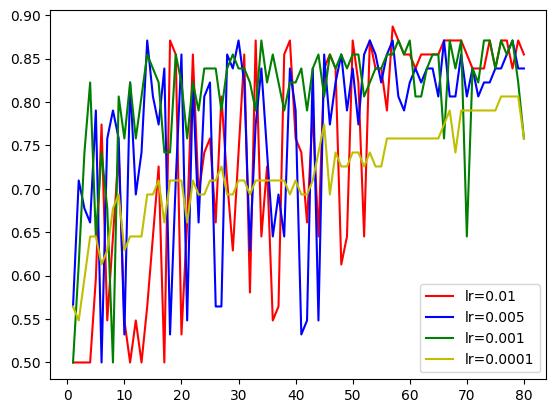

In [128]:
# Epocas del eje X
VGG16_001_val_acc = VGG16_001_val_acc1 + VGG16_001_val_acc2
VGG16_0005_val_acc = VGG16_0005_val_acc1 + VGG16_0005_val_acc2
VGG16_0001_val_acc = VGG16_0001_val_acc1 + VGG16_0001_val_acc2
VGG16_00001_val_acc = VGG16_00001_val_acc1 + VGG16_00001_val_acc2
epochs = range(1, len(VGG16_001_val_acc) + 1)

# Representamos las gráficas
plt.plot(epochs, VGG16_001_val_acc, 'r', label='lr=0.01')
plt.plot(epochs, VGG16_0005_val_acc, 'b', label='lr=0.005')
plt.plot(epochs, VGG16_0001_val_acc, 'g', label='lr=0.001')
plt.plot(epochs, VGG16_00001_val_acc, 'y', label='lr=0.0001')

# Incluir leyenda
plt.legend(loc='best')

# Mostrar la figura
plt.show()